# Evolving cellular automata with genetic algorithms

Preamble: Run the cells below to import the necessary Python packages

*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*

In [2]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

# Add the course directory to the Python path
import sys
sys.path.append('../') 
import cphy.plotting as cplot


# Gradient-free optimization

+ We saw before that many optimization methods implicitly require the locally-computed gradient of the potential, either explicitly or a finite-difference approximation

+ However, in many contexts this gradient is not available or is too expensive to compute

+ Today, we will consider a case where the gradient is impossible to compute, because the underlying system is discrete



# Genetic algorithms

+ We define a set of candidate solutions to a problem, called the *population*

+ We then iteratively select the best solutions from the population using a *fitness* function

+ We use the best solutions to create new "offspring" solutions using a combination of *mutation* and *crossover*. The former corresponds to a random change in the solution, while the latter corresponds to combining two solutions to create a new one.

+ The offspring solutions are then added to the population, and they usually replace the worst solutions

# Evolving cellular automata

+ Cellular automata take discrete values, and update on a discrete grid in discrete time steps

+ This discrete nature precludes the use of gradient-based methods when analyzing their behavior

Influential results that exploring the space of CA with genetic algorithms can be found in [Mitchell et al. 1993](https://arxiv.org/abs/adap-org/9303003) and [Mitchell and Crutchfield 1995](https://www.pnas.org/doi/10.1073/pnas.92.23.10742) 

In [27]:
class CellularAutomaton:
    """
    A base class for cellular automata. Subclasses must implement the step method.

    Parameters
        n (int): The number of cells in the system
        n_states (int): The number of states in the system
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.
        initial_state (None or array): The initial state of the system. If None, a 
            random initial state is used.
        
    """
    def __init__(self, n, n_states, random_state=None, initial_state=None):
        self.n_states = n_states
        self.n = n
        self.random_state = random_state

        np.random.seed(random_state)

        ## The universe is a 2D array of integers
        if initial_state is None:
            self.initial_state = np.random.choice(self.n_states, size=(self.n, self.n))
        else:
            self.initial_state = initial_state
        self.state = self.initial_state

        self.history = [self.state]

    def next_state(self):
        """
        Output the next state of the entire board
        """
        return NotImplementedError

    def simulate(self, n_steps):
        """
        Iterate the dynamics for n_steps, and return the results as an array
        """
        for i in range(n_steps):
            self.state = self.next_state()
            self.history.append(self.state)
        return self.state


We want to represent the space of *rules*, which are discrete-valued functions that take in a neighborhood of cells and return a new value for the center cell

+ We consider only binary cellular automata like Conway's Game of Life, for which a given cell can be either "alive" (1) or "dead" (0)

+ For a Moore neighborhood CA (nearest neighbors including diagonal), there are $2^9 = 512$ possible input values if we include the center cell

+ For each input value, there are two possible output values. Therefore, there are $2^{2^9} \approx 10^{154}$ possible rules.

We therefore define a subclass, `ProgrammaticCA`, which takes a ruleset in its constructor and defines the corresponding CA. We saw previously that many common CA may be quickly implemented using 2D convolutions with an appropriate kernel. For our implementation, we define a special convolutional kernel that converts a 3x3 neighborhood into a unique integer between 0 and 511. We then use this integer to index into the ruleset to determine the output value.

Text(0.5, 1.0, 'Final state')

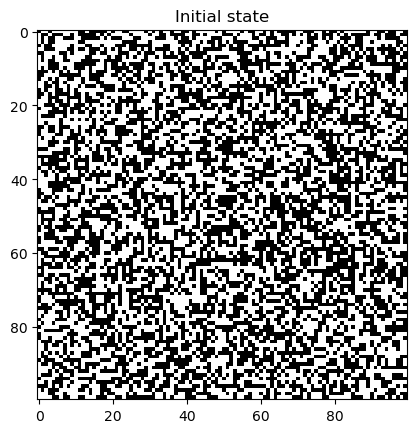

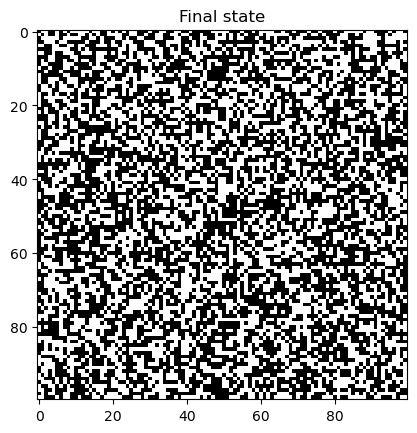

In [31]:
from scipy.signal import convolve2d

class ProgrammaticCA(CellularAutomaton):

    def __init__(self, n, ruleset,  **kwargs):
        k = np.unique(ruleset).size
        super().__init__(n, k, **kwargs)
        self.ruleset = ruleset

        ## A special convolutional kernel for converting a binary neighborhood 
        ## to an integer
        self.powers = np.reshape(2 ** np.arange(9), (3, 3))

    def next_state(self):

        # Compute the next state
        next_state = np.zeros_like(self.state)
        
        # convolve with periodic boundary conditions
        rule_indices = convolve2d(self.state, self.powers, mode='same', boundary='wrap')

        ## look up the rule for each cell
        next_state = self.ruleset[rule_indices.astype(int)]

        return next_state

# An entire CA can be represented as a single binary integer
random_ruleset = np.random.choice(2, size=2**9)

model = ProgrammaticCA(100, random_ruleset, random_state=0)
model.simulate(500)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

## Searching the space of cellular automata with genetic algorithms

We are now ready to define a genetic algorithm that searches the space of cellular automata for interesting behavior.

In [220]:
## Evolve towards shifting

def fitness(state, target_state, shift=1):
    """
    A fitness function that rewards shifting
    """
    # return np.sum(state[1:] == (1 - state[:-1])) / state[:-1].size
    # return np.sum(target_state[shift:] == state[:-shift]) / state[:-shift].size
    # return -np.sum(np.abs(target_state[shift:] - state[:-shift])) / state[:-shift].size
    # return np.sum(1 - state) # extinction fitness
    return np.std(state) # activity


def evolve(n_workers=50, n_generations=100, n_steps=10, n=100, random_state=None, verbose=False):
    """
    Evolve a rule set using a genetic algorithm
    """
    np.random.seed(random_state)
    rulesets = np.random.choice(2, size=(n_workers, 2**9))

    fitnesses = []
    for i in range(n_generations):
        if i % (n_generations // 20) == 0 and verbose:
            print("Generation", i + 1)

        all_fitnesses = []
        for ruleset in rulesets:

            model = ProgrammaticCA(n, ruleset, random_state=0)
            initial_state = model.state.copy()
            model.simulate(n_steps)
            final_state = model.state.copy()

            fitness_val = fitness(final_state, initial_state)
            all_fitnesses.append(fitness_val)

        # "Elitist" modification: Select the top 10 rulesets
        top_rulesets = rulesets[np.argsort(all_fitnesses)[-500:]]
        n_top = top_rulesets.shape[0]



        # Create a new generation
        new_rulesets = []
        for _ in range(n_workers):
            
            ## Crossover two rulesets
            parent_1 = top_rulesets[np.random.randint(n_top)]
            parent_2 = top_rulesets[np.random.randint(n_top)]
            crossover_point = np.random.randint(2**9)
            # crossover_point = 0
            child = np.hstack((parent_1[:crossover_point], parent_2[crossover_point:]))

            ## Mutate the child at random points
            child[np.random.randint(2**9, size=100)] = np.random.randint(2, size=100)

            new_rulesets.append(child)

        new_rulesets = np.array(new_rulesets)

        ## Propagate the top 10 rulesets and the random rulesets
        new_rulesets[:len(top_rulesets)] = top_rulesets

        # "Survival": Select 10 random rulesets to survive
        # random_rulesets = rulesets[np.random.randint(n_workers, size=n_top)]
        # new_rulesets[-n_top:] = random_rulesets

        rulesets = new_rulesets

        fitnesses.append(np.mean(all_fitnesses))

    # Return the best ruleset
    best_ruleset = rulesets[np.argmax(all_fitnesses)]

    return fitnesses, best_ruleset

fitnesses, best_ruleset = evolve(n_workers=1000, n_generations=1000, n_steps=200, n=10, verbose=True)

plt.figure()
plt.plot(fitnesses)

Generation 1
Generation 51
Generation 101
Generation 151
Generation 201
Generation 251
Generation 301
Generation 351
Generation 401
Generation 451
Generation 501
Generation 551
Generation 601
Generation 651
Generation 701
Generation 751
Generation 801
Generation 851


Text(0.5, 1.0, 'Final state')

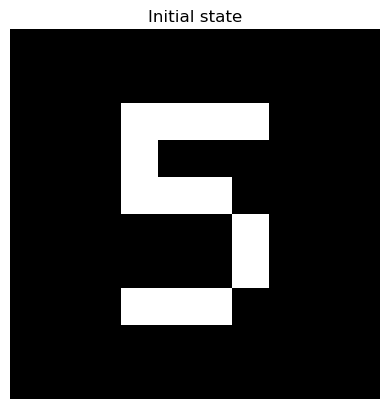

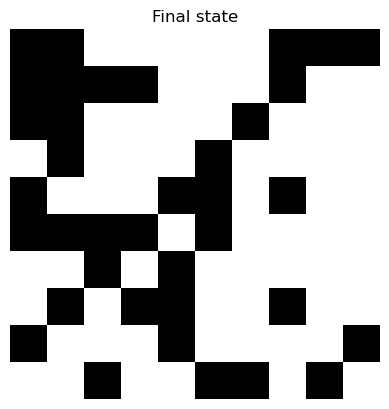

In [212]:
digit_5 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])
# digit_5 = np.logical_not(digit_5)

model = ProgrammaticCA(10, best_ruleset, random_state=0, initial_state=digit_5)
model.simulate(600)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.axis("off")
plt.title("Initial state")


plt.figure()
plt.imshow(model.state, cmap="gray")
plt.axis("off")
plt.title("Final state")


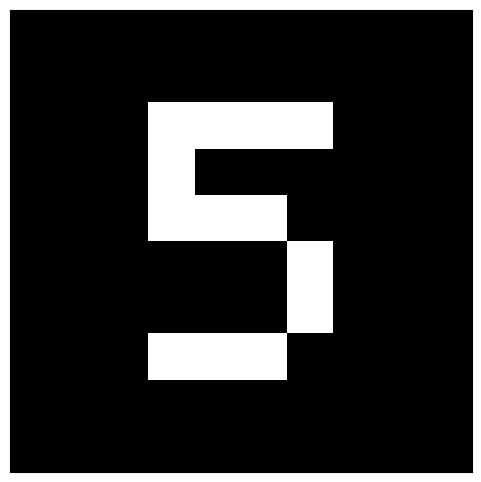

In [213]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = np.array(model.history).copy() 

fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0], vmin=0, vmax=1, cmap="gray");
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
    img.set_array(frame)

ani = FuncAnimation(fig, update, frames=frames, interval=500)
HTML(ani.to_jshtml())